In [4]:
import pandas as pd

df = pd.read_csv("/Users/macbook/Documents/GitHub/DSfinProject/dsfinlendclub/data/01_raw/Loan_status_sample.csv", low_memory=False)
df.head(5)

,Unnamed: 0.1,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,1746494,25450,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,2370717,81861,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2264870,397109,39589826,5000.0,5000.0,5000.0,36 months,10.49%,162.49,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,595422,15492,134798709,24000.0,24000.0,24000.0,60 months,11.05%,522.42,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,562657,90591,127097355,14000.0,14000.0,14000.0,60 months,13.59%,322.79,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [5]:
print(df.shape)  # Check dataset dimensions
print(df.info())  # Check data types and missing values

(100000, 143)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 143 entries, Unnamed: 0.1 to debt_settlement_flag
dtypes: float64(106), int64(3), object(34)
memory usage: 109.1+ MB
None


### Exploration

In [6]:
# Drop columns with too many missing values
missing_threshold = 0.6  # Set 60% as a threshold
df = df[df.columns[df.isnull().mean() < missing_threshold]]

# Fill numeric columns with median
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with "Unknown"
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")


In [7]:
df['issue_d'].head()

0    Mar-2020
1    Feb-2016
2    Jan-2015
3    Jun-2018
4    Jan-2018
Name: issue_d, dtype: object

In [8]:
# Convert date columns
format='%Y-%m-%d'

df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%Y-%m-%d', errors='coerce')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d', errors='coerce')


# Add new features
df = df.assign(
    credit_history_length=(df['issue_d'] - df['earliest_cr_line']).dt.days / 365,
    income_to_loan_ratio=df['annual_inc'] / df['loan_amnt'],
    loan_utilization=df['revol_bal'] / df['total_rev_hi_lim'],
    is_recent_delinquent=(df['mths_since_last_delinq'] < 12).astype(int)
).copy()


In [9]:
from sklearn.preprocessing import LabelEncoder

# Ordinal encoding for loan grades
grade_order = ["A", "B", "C", "D", "E", "F", "G"]
df['grade'] = df['grade'].apply(lambda x: grade_order.index(x) if x in grade_order else -1)

# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['home_ownership', 'purpose', 'addr_state'], drop_first=True)


### Exploratory Data Analysis (EDA)

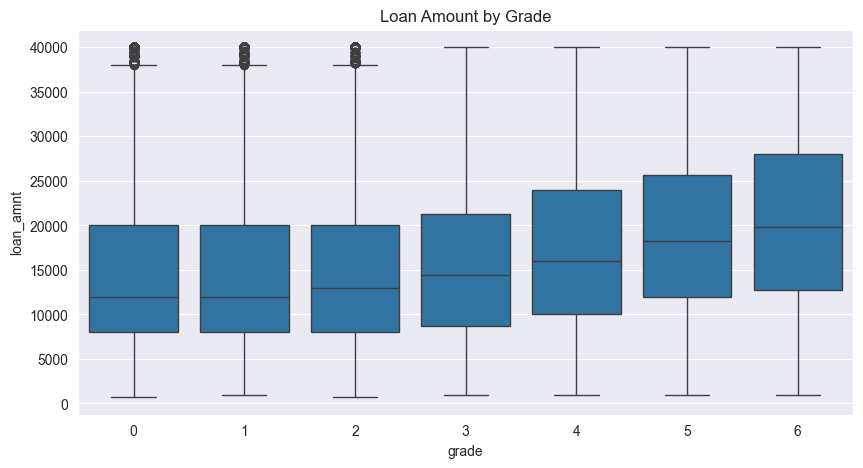

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x=df["grade"], y=df["loan_amnt"])
plt.title("Loan Amount by Grade")
plt.show()

In [11]:
df[df['income_to_loan_ratio'] > 20].head()

,Unnamed: 0.1,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
17,1449569,92412,160853580,2400.0,2400.0,2400.0,36 months,8.19%,75.42,0,...,False,False,False,False,False,False,False,False,False,False
36,17533,17533,715030,3500.0,3500.0,3450.0,36 months,5.79%,106.15,0,...,False,False,False,False,False,False,False,False,False,False
43,1011406,44098,147969933,4725.0,4725.0,4725.0,36 months,14.74%,163.20,2,...,False,False,False,False,False,False,False,False,False,False
129,574571,102505,126437506,6100.0,6100.0,6100.0,36 months,26.30%,246.75,4,...,False,False,False,True,False,False,False,False,False,False
132,1292807,78685,156745712,4000.0,4000.0,4000.0,36 months,10.33%,129.69,1,...,False,False,False,False,False,False,False,False,False,False


### Model Development
 Define Target Variables
Fraud Detection → fraud_flag (Derived from anomalies)
Loan Default Prediction → loan_status
Convert loan_status to binary: Charged Off, Default, and Late are 1, others are 0.

In [12]:
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default', 'Late'] else 0)

In [13]:

df['loan_utilization'] = df['loan_utilization'].fillna(df['loan_utilization'].median())
df['credit_history_length'] = df['credit_history_length'].fillna(df['credit_history_length'].median())

/Users/macbook/tensorflow-m1/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [14]:
from sklearn.model_selection import train_test_split

X = df[['income_to_loan_ratio', 'loan_utilization', 'credit_history_length', 'grade']]
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X.isnull().sum()

income_to_loan_ratio          0
loan_utilization              0
credit_history_length    100000
grade                         0
dtype: int64

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Evaluation

In [ ]:
import numpy as np

df['model_pred'] = model.predict(X)
df[['grade', 'loan_status', 'model_pred']].groupby('grade').mean()